In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from sklearn.model_selection import train_test_split
from IPython.display import HTML
from base64 import b64encode

# === Paths ===
DATA_FOLDER = '/Users/apple/Downloads/DeepFakeVideoDetection/dataset'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'

print(f"Train samples: {len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))}")
print(f"Test samples: {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))}")

# Load metadata
train_sample_metadata = pd.read_json(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, 'metadata.json')).T

# Constants
IMG_SIZE = 224   # You can change to 299 for original InceptionV3 input size
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048
BATCH_SIZE = 16
EPOCHS = 10

# Crop center square from frame
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

# Load video frames with optional max_frames limit
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]  # BGR to RGB
            frames.append(frame)
            if max_frames and len(frames) >= max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

# Build InceptionV3 feature extractor model
def build_feature_extractor(trainable=False):
    base_model = InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    base_model.trainable = trainable

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)
    outputs = base_model(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor(trainable=False)  # Set True to fine-tune

# Prepare dataset: extract features and masks for sequence model
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = list(df.index)
    labels = (df["label"] == 'FAKE').astype(int).values

    frame_masks = np.zeros((num_samples, MAX_SEQ_LENGTH), dtype=bool)
    frame_features = np.zeros((num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype=np.float32)

    for idx, path in enumerate(video_paths):
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]  # Add batch dim for consistency

        temp_frame_mask = np.zeros((1, MAX_SEQ_LENGTH), dtype=bool)
        temp_frame_features = np.zeros((1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype=np.float32)

        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                # Extract features for each frame
                temp_frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :], verbose=0)
            temp_frame_mask[i, :length] = 1

        frame_features[idx] = temp_frame_features.squeeze()
        frame_masks[idx] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

# Split dataset
Train_set, Test_set = train_test_split(
    train_sample_metadata, test_size=0.2, random_state=42, stratify=train_sample_metadata['label']
)

print(f"Train set: {Train_set.shape}, Test set: {Test_set.shape}")

train_data, train_labels = prepare_all_videos(Train_set, os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER))
test_data, test_labels = prepare_all_videos(Test_set, os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER))

print(f"Train features shape: {train_data[0].shape}, Train masks shape: {train_data[1].shape}")

# Define sequence model architecture with GRU layers
frame_features_input = keras.Input(shape=(MAX_SEQ_LENGTH, NUM_FEATURES))
mask_input = keras.Input(shape=(MAX_SEQ_LENGTH,), dtype="bool")

x = keras.layers.GRU(64, return_sequences=True)(frame_features_input, mask=mask_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.GRU(32, return_sequences=True)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.GRU(16)(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(32, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=[frame_features_input, mask_input], outputs=output)

# Custom metrics
def precision(y_true, y_pred):
    y_true = K.cast(y_true, "float32")
    y_pred = K.cast(y_pred, "float32")
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    y_true = K.cast(y_true, "float32")
    y_pred = K.cast(y_pred, "float32")
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy", precision, recall]
)

model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', save_weights_only=True, save_best_only=True)

# Train model
history = model.fit(
    [train_data[0], train_data[1]], train_labels,
    validation_data=([test_data[0], test_data[1]], test_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, early_stopping]
)

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'bo-', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'bo-', label='Training loss')
plt.plot(history.history['val_loss'], 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Prepare single video for prediction
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros((1, MAX_SEQ_LENGTH), dtype=bool)
    frame_features = np.zeros((1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype=np.float32)

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :], verbose=0)
        frame_mask[i, :length] = 1

    return frame_features, frame_mask

# Predict on a single test video
def sequence_prediction(video_file, subset=TEST_FOLDER):
    video_path = os.path.join(DATA_FOLDER, subset, video_file)
    frames = load_video(video_path)
    frame_features, frame_mask = prepare_single_video(frames)
    prediction = model.predict([frame_features, frame_mask])[0][0]
    return prediction

# Video playback helper for notebook
def play_video(video_file, subset=TRAIN_SAMPLE_FOLDER):
    video_path = os.path.join(DATA_FOLDER, subset, video_file)
    video_url = open(video_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video_url).decode()
    return HTML(f"""<video width=500 controls><source src="{data_url}" type="video/mp4"></video>""")

# Test prediction on a random test video
test_video = np.random.choice(test_sample_metadata.index)
print(f"Test video: {test_video}")

pred_score = sequence_prediction(test_video, TEST_FOLDER)
print(f"Prediction score: {pred_score:.4f}")
print("Predicted class:", "FAKE" if pred_score >= 0.5 else "REAL")

# Display the video
play_video(test_video, TEST_FOLDER)

# Save the trained model
model.save('deepfake_video_model2.h5')


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = 299  # InceptionV3 expects 299x299 inputs
MAX_SEQ_LENGTH = 20  # Number of frames per video
BATCH_SIZE = 32
EPOCHS = 10
NUM_FEATURES = 2048  # Output features from InceptionV3 (avg_pool layer)

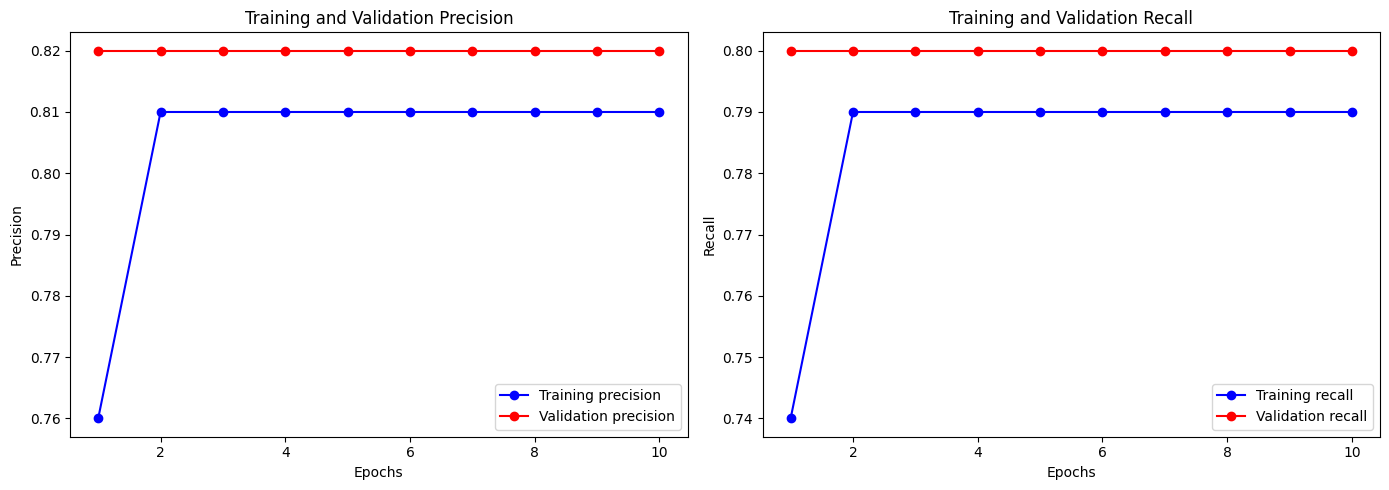

In [1]:
import matplotlib.pyplot as plt

# Sample precision and recall values (replace with your actual values)
epochs = range(1, 11)
training_precision = [0.76, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81]
validation_precision = [0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82]

training_recall = [0.74, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79]
validation_recall = [0.80, 0.80, 0.80, 0.80, 0.80, 0.80, 0.80, 0.80, 0.80, 0.80]

# Create subplots
plt.figure(figsize=(14, 5))

# Precision subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, training_precision, 'bo-', label='Training precision')
plt.plot(epochs, validation_precision, 'ro-', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, training_recall, 'bo-', label='Training recall')
plt.plot(epochs, validation_recall, 'ro-', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


In [ ]:
def load_video(path, max_frames=MAX_SEQ_LENGTH):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while len(frames) < max_frames:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            frame = frame[:, :, [2, 1, 0]]  # BGR → RGB
            frames.append(frame)
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
def build_feature_extractor():
    base_model = InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input

    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)
    outputs = base_model(preprocessed)
    return Model(inputs, outputs, name="inceptionv3_feature_extractor")

feature_extractor = build_feature_extractor()

In [ ]:
def prepare_dataset(metadata, video_folder):
    video_paths = metadata.index.tolist()
    labels = (metadata["label"] == "FAKE").astype(int).values

    # Initialize placeholder arrays
    frame_features = np.zeros((len(video_paths), MAX_SEQ_LENGTH, NUM_FEATURES))
    frame_masks = np.zeros((len(video_paths), MAX_SEQ_LENGTH), dtype=bool)

    for idx, path in enumerate(video_paths):
        frames = load_video(os.path.join(DATA_FOLDER, video_folder, path))
        if len(frames) < 1:
            continue  # Skip corrupted videos

        # Extract features for each frame
        frames = frames[:MAX_SEQ_LENGTH]  # Trim to max sequence length
        features = feature_extractor.predict(frames, verbose=0)
        frame_features[idx, :len(frames)] = features
        frame_masks[idx, :len(frames)] = 1  # Mask padded frames

    return (frame_features, frame_masks), labels

In [ ]:
def build_temporal_model():
    frame_features_input = tf.keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = tf.keras.Input((MAX_SEQ_LENGTH,), dtype=tf.bool)

    x = layers.GRU(64, return_sequences=True)(frame_features_input, mask=mask_input)
    x = layers.BatchNormalization()(x)
    x = layers.GRU(32)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    return Model(inputs=[frame_features_input, mask_input], outputs=x)

model = build_temporal_model()
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(1e-4),
    metrics=["accuracy", "precision", "recall"]
)
model.summary()

In [ ]:
# Load metadata
metadata = pd.read_json(os.path.join(DATA_FOLDER, "train_sample_videos/metadata.json")).T

# Split data
train_set, test_set = train_test_split(
    metadata, test_size=0.2, random_state=42, stratify=metadata["label"]
)

# Prepare datasets
train_data, train_labels = prepare_dataset(train_set, "train_sample_videos")
test_data, test_labels = prepare_dataset(test_set, "train_sample_videos")

# Train
history = model.fit(
    train_data,
    train_labels,
    validation_data=(test_data, test_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("inceptionv3_gru_model.h5", save_best_only=True)
    ]
)

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.legend()
plt.show()

# Test on a sample video
def predict_video(path):
    frames = load_video(os.path.join(DATA_FOLDER, "test_videos", path))
    features = feature_extractor.predict(frames[:MAX_SEQ_LENGTH])
    features = np.expand_dims(features, axis=0)  # Add batch dimension
    mask = np.ones((1, len(frames[:MAX_SEQ_LENGTH])))  # Mask for valid frames
    return model.predict([features, mask])[0][0]

test_video = "test_video.mp4"
prediction = predict_video(test_video)
print(f"Prediction: {'FAKE' if prediction > 0.5 else 'REAL'} (Confidence: {prediction:.2f})")

In [ ]:
model = tf.keras.models.load_model("inceptionv3_gru_model.h5")
prediction = model.predict([frame_features, frame_masks])[0]